# 6-Body Solar System IRKGL (Errebersiblea)

<ul id="top">
<li><a href="#Loading-packages-and-functions"> 
             Loading packages and functions</a></li>
    
<li><a href="#Definition-of-the-N-body-problem"> 
             Definition of the N-body problem</a></li>  

<li><a href="#Integration-with-constant-stepsize">
             Integration with constant stepsize</a></li>

<li><a href="#Integration-with-adaptive-stepsize">
             Integration with adaptive stepsize</a></li>
             
<li><a href="#Comparison">
               Comparison</a></li>

</ul> 


## Loading packages and functions

In [1]:
using LinearAlgebra
using Plots, LaTeXStrings
using DataFrames
using OrdinaryDiffEq

In [2]:
PATH_DATA="./Data/"

PATH_SRC="../../src/simd/"
include(string(PATH_SRC,"IRKGL_SIMD.jl"))
using .IRKGL_SIMD   

PATH_SRC="../../src/simd-new/"
include(string(PATH_SRC,"IRKGL_SIMD_NEW.jl"))
using .IRKGL_SIMD_NEW   

PATH_SRC="../../src/seq/"
include(string(PATH_SRC,"IRKGL_SEQ.jl"))
using .IRKGL_SEQ  

##### <a href="#top">Back to the top</a>

## Definition of the N-body problem

In [3]:
PATH_ODES="../../ODEProblems/"

include(string(PATH_ODES,"Initial6Body.jl"))
include(string(PATH_ODES,"Nbody.jl"))
include(string(PATH_ODES,"Nbody2nd.jl"))
include(string(PATH_ODES,"NbodyDyn.jl"));

### Initial value problem: 6-body problem (outer solar system)

We consider $N=6$ bodies of the outer solar system: the Sun, Jupiter, Saturn, Uranus, Neptune and Pluto.
The initial values $u_{00}$ are taken from DE430, Julian day (TDB) 2440400.5 (June 28, 1969). 

In [4]:
u0, Gm, bodylist = Initial6Body(Float64)
u0_B, Gm_B, bodylist = Initial6Body(BigFloat)

q0=u0[:,:,1]
v0=u0[:,:,2]
dim=length(size(u0))

N = length(Gm)

show(bodylist)
E0=NbodyEnergy(u0,Gm)

["Sun" "Jupiter" "Saturn" "Uranus" "Neptune" "Pluto"]

-9.522620605966966e-12

In [5]:
# Egoera aldagai bat gehitu dut: tau edo t integrazioan kalkulatzeko
u0R=fill(zero(eltype(u0)),(3,N+1,2))
u0R[1:3,1:N,1:2].=u0[:,:,:];

In [6]:
t0=0.
tF=1e6   #1e9  # days


tspan= (t0,tF)
dim=length(size(u0))
prob1 = ODEProblem(NbodyODE!, u0,tspan , Gm)
prob2 = ODEProblem(NbodyODEer2!, u0R,tspan , Gm);


 <a href="#top">Back to the top</a>

## Integration with constant stepsize

In [7]:
m=1
dt=225.
saveat=m*dt

steps_irkn=(tF-t0)/dt

println("dt = $dt, steps=$steps_irkn,  m=$m, n=$(tF/saveat)")

alg=IRKGL_seq(m=m, initial_extrap=0)

sol1=solve(prob1,alg,dt=dt, adaptive=false);

[sol1.stats.nf sol1.stats.naccept]


dt = 225.0, steps=4444.444444444444,  m=1, n=4444.444444444444


1×2 Matrix{Int64}:
 551832  4445

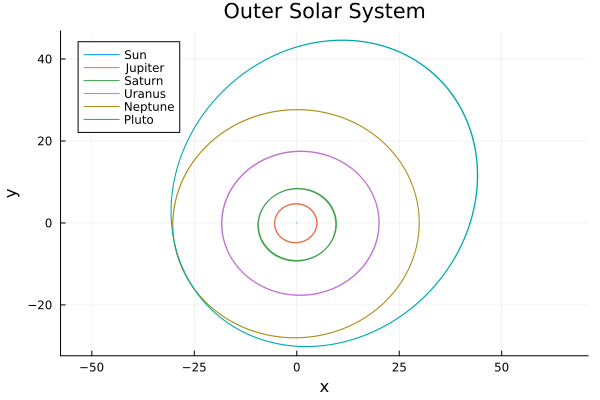

In [8]:
pl = plot(title="Outer Solar System", 
            xlabel="x", ylabel="y",  aspect_ratio=1)

for j = 1:6
    x  = [u[1,j,1] for u in sol1.u]
    y  = [u[2,j,1] for u in sol1.u] 
    pl = plot!(x,y, label=bodylist[j]) 
end 
display(pl)

 <a href="#top">Back to the top</a>

## Integration with adaptive stepsize

In [9]:
alg=IRKGL_seq(m=m, initial_extrap=0, Dtau=1.)

sol2=solve(prob2,alg,dt=dt, adaptive=true)

steps=sol2.t[2:end]-sol2.t[1:end-1]
nsteps=length(steps)
println("dt = $dt, steps=$nsteps,  m=$m, n=$(tF/saveat)")

@show sol2.retcode

[sol2.stats.nf sol2.stats.naccept]

dt = 225.0, steps=4558,  m=1, n=4444.444444444444
sol2.retcode = SciMLBase.ReturnCode.Success


1×2 Matrix{Int64}:
 754792  4558

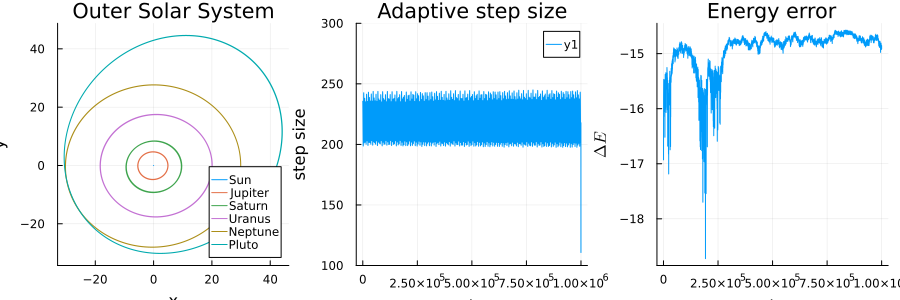

In [10]:
pl = plot(title="Outer Solar System", 
            xlabel="x", ylabel="y",  aspect_ratio=1)

for j = 1:6
    x  = [u[1,j,1] for u in sol2.u]
    y  = [u[2,j,1] for u in sol2.u] 
    pl = plot!(x,y, label=bodylist[j]) 
end 

pl2=plot(sol2.t[1:end-1],steps,
    xlabel="t", ylabel="step size",
    ylims=(100,300),title="Adaptive step size")

E0=NbodyEnergy(u0_B, Gm_B)
ΔE2 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), sol2.u)./E0.-1
pl3=plot(title="Energy error", xlabel="t", ylabel=L"\Delta E")
pl3=plot!(sol2.t,log10.(abs.(ΔE2)), label="")

plot(pl,pl2, pl3, layout=(1,3), size=(900,300))

 <a href="#top">Back to the top</a>

## Integration-Time-Renormalization

In [11]:
tau0=0.
TauF=sol2.u[end][1,N+1,1]
tauspan= (tau0,TauF)
prob3 = ODEProblem(NbodyODERen!, u0R,tauspan, Gm);

In [12]:
m=1
alg=IRKGL_seq(m=m, initial_extrap=0)

sol3=solve(prob3,alg, dt=1., adaptive=false)

steps=sol3.t[2:end]-sol3.t[1:end-1]
nsteps=length(steps)

tR=[u[1,N+1,1] for u in sol3.u];

@show sol3.retcode,nsteps

[sol3.stats.nf sol3.stats.naccept]

(sol3.retcode, nsteps) = (SciMLBase.ReturnCode.Success, 4558)


1×2 Matrix{Int64}:
 538144  4558

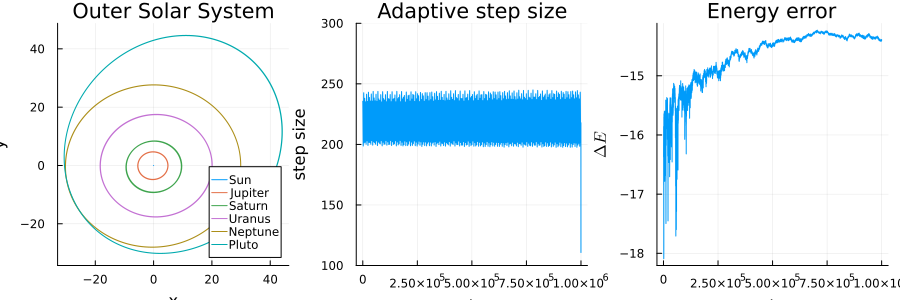

In [13]:
pl = plot(title="Outer Solar System", 
            xlabel="x", ylabel="y",  aspect_ratio=1)

for j = 1:N
    x  = [u[1,j,1] for u in sol3.u]
    y  = [u[2,j,1] for u in sol3.u] 
    pl = plot!(x,y, label=bodylist[j]) 
end 

pl2=plot(xlabel="t", ylabel="step size",title="step size")
steps =tR[2:end]-tR[1:end-1]
pl2=plot!(tR[1:end-1],steps, label="",
          xlabel="t", ylabel="step size",
          ylims=(100,300),title="Adaptive step size")

E0=NbodyEnergy(u0_B, Gm_B)
ΔE3 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), sol3.u)./E0.-1
pl3=plot(title="Energy error", xlabel="t", ylabel=L"\Delta E")
pl3=plot!(tR,log10.(abs.(ΔE3)), label="")

plot(pl,pl2, pl3, layout=(1,3), size=(900,300))

 <a href="#top">Back to the top</a>

## Comparison

 ### Energy Error

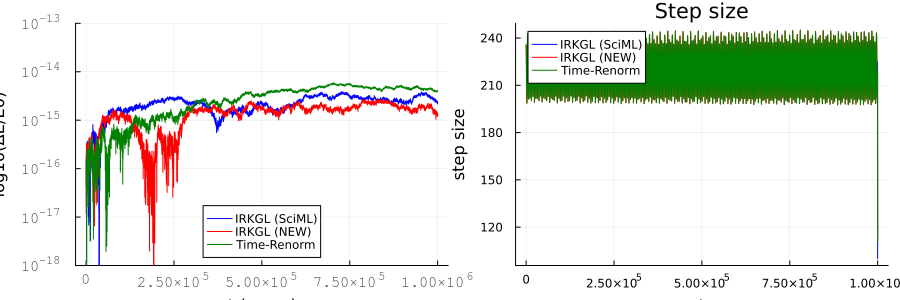

In [17]:
E0=NbodyEnergy(u0_B, Gm_B)
yrange=(1e-18,1e-13)
ΔE1 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), sol1.u)./E0.-1
ΔE2 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), sol2.u)./E0.-1
ΔE3 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), sol3.u)./E0.-1

plot(title="",xlabel="t (years)", ylabel="log10(ΔE/E0)", 
     yscale=:log10, ylims=yrange,
     xtickfont = font(8, "Courier"),
     ytickfont = font(8, "Courier"),
     legend=:bottom)

pl1=plot!(sol1.t,abs.(ΔE1),label="IRKGL (SciML)", color="blue")
pl1=plot!(sol2.t,abs.(ΔE2),label="IRKGL (NEW)", color="red")
pl1=plot!(tR,abs.(ΔE3),label="Time-Renorm", color="green")

pl2=plot(xlabel="t", ylabel="step size",title="Step size",legend=:topleft)
steps1 =sol1.t[2:end]-sol1.t[1:end-1]
pl2=plot!(sol1.t[1:end-1],steps1,label="IRKGL (SciML)", color="blue")
steps2 =sol2.t[2:end]-sol2.t[1:end-1]
pl2=plot!(sol2.t[1:end-1],steps2,label="IRKGL (NEW)", color="red")
steps3 =tR[2:end]-tR[1:end-1]
pl3=plot!(tR[1:end-1],steps3,label="Time-Renorm", color="green")

plot(pl1,pl2, layout=(1,2), size=(900,300))

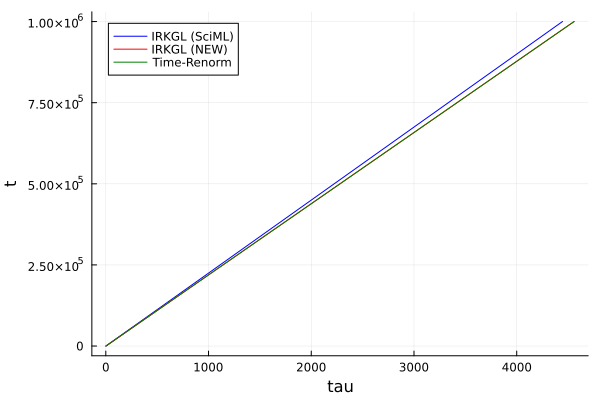

In [15]:
# t-ren taurekiko eboluzioa aztertzeko grafikoa
# ( kontutan hartuta, tau urrats kopuruaren proportzionala dela)
plot(sol1.t, xlabel="tau", ylabel="t", label="IRKGL (SciML)", color="blue")
plot!(sol2.t, label="IRKGL (NEW)", color="red")
plot!(tR, label="Time-Renorm", color="green")

### Summary

In [16]:
summary=DataFrame()
summary.Steps_SciML=[sol1.stats.naccept]
summary.Steps_New=[sol2.stats.naccept]
summary.Steps_Reg=[sol3.stats.naccept]
summary.it_SciML=[sol1.stats.nf/sol1.stats.naccept/8]
summary.it_New=[sol2.stats.nf/sol2.stats.naccept/8]
summary.it_Reg=[sol3.stats.nf/sol3.stats.naccept/8]
show(summary)

1×6 DataFrame
 Row │ Steps_SciML  Steps_New  Steps_Reg  it_SciML  it_New   it_Reg  
     │ Int64        Int64      Int64      Float64   Float64  Float64 
─────┼───────────────────────────────────────────────────────────────
   1 │        4445       4558       4558   15.5183  20.6996  14.7582